# Processo Numérico de Interpolação de Imagens via Equação de Transporte e Runge-Kutta  

O processo de interpolação de imagens é definido como gerar uma imagem intermediária entre dois frames consecutivos, mantendo características de movimento e repouso.

É um processo em grande parte baseado em estimação de movimentos, que derivam diversas outras aplicações, como:
- predição de quadros e compressão de vídeo;
- aumento da taxa de quadros (*frame interpolation*);
- remoção de objetos estáticos ou compensação de movimento.

Uma das possibilidades de resolução desse problema é baseada em estimativa do [fluxo ótico](https://en.wikipedia.org/wiki/Optical_flow), onde diversos métodos e algoritmos são utilizados para analisar as diferenças entre os frames e estimar o campo de fluxo.

Porém, dado um fluxo, precisamos resolver o frame intermediário da interpolação, e para isso podemos modelar a evolução da imagem como um problema de transporte, podendo ser resolvido numericamente com diferentes técnicas.

Esse trabalho se baseia principalmente no artigo [Image sequence interpolation using optimal control](https://arxiv.org/abs/1008.0548).

## Modelagem

Dadas duas imagens:

- $u_0(x)$: imagem no tempo $t=0$
- $u_1(x)$: imagem no tempo $t=1$

queremos gerar quadros intermediários:

$$
u(t, x), \quad 0 < t < 1
$$

Queremos uma interpolação que respeite o movimento dos elementos em cena, não apenas misture imagens como um cross-fade.

Modelamos a imagem como densidade sendo transportada por um fluido, utilizando a equação do transporte.


## A equação de transporte

Assumimos que cada ponto da imagem (pixel) se move com velocidade dada por um fluxo:

$$
b(x) \in \mathbb{R}^2
$$

A imagem obedece à EDP:

$$
\frac{\partial u}{\partial t} + b \cdot \nabla u = 0.
$$

Onde:

- $u(t, x)$ = intensidade da imagem  
- $b(x)$ = velocidade local dos pixels  

Nessa modelagem, a imagem "viaja" no espaço segundo o fluxo definido.

## Solução pela fórmula das características

A solução não é obtida diretamente.  
Usamos as características, que satisfazem a EDO:

$$
\dot{\gamma}(t) = b(\gamma(t)), \qquad \gamma(0) = x_0.
$$

Ao longo dessa trajetória:

$$
u(t, \gamma(t)) = u_0(\gamma(0)).
$$

Ou seja, temos que para descobrir o valor de um pixel no tempo $t$, basta seguir o fluxo até a posição inicial.


## Determinando o fluxo $b(x)$

A equação do transporte apresentada precisa do campo de fluxo $b(x)$, que representa a velocidade do movimeto dos pixels. Existem diversas formas descritas na literatura para obter esse fluxo, dependendo da aplicação e modelagem adotada:

### Fluxo ótico tradicional

O fluxo $b$ pode ser estimado a partir dos dois frames utilizando algoritmos de fluxo ótico, como:

- Horn-Schunck
- Lucas-Kanade
- Farneback
- TV-L1

Uma comparação de alguns métodos pode ser encontrada no seguinte artigo: [Comparação de métodos para localização de fluxo óptico em sequências de imagens](http://www.decom.ufop.br/menotti/paa111/files/PCC104-111-ars-11.1-VantuilJoseDeOliveiraNeto.pdf)

Podemos uma visualização do método de Farneback [neste link](https://www.youtube.com/watch?v=Tqf2EzG0djQ).

### Controle ótimo

É possivel considerar obter o fluxo como solução de um problema de [controle ótimo](https://en.wikipedia.org/wiki/Optimal_control), que pode ser descrito como:

> Busque um campo que transporta $u_1$ até  $u_2$ minimizando um funcional de energia e obedecendo restrições.

Nessa abordagem, $b$ é uma variável a ser otimizada, resolvida iterativamente através de:
1. Resolvendo a equação do transporte forward de $u$;
2. Resolvendo a equação do transporte backward do adjunto $p$;
3. Atualização de $b$ por uma equação do tipo Stokes.

### Métodos baseados em aprendizado profundo

Estudos recentes estão trazendo abordagens com redes neurais e têm alcançado ótimos resultados na estimação de movimento, e podem ser usadas para fornecer o fluxo. Alguns exemplos são:
- [FlowNet](https://arxiv.org/abs/1504.06852);
- [PWC-Net](https://arxiv.org/abs/1709.02371);
- [RAFT](https://arxiv.org/abs/2003.12039).

Ou alguns métodos próprios para interpolação de video:
- [SuperSloMo](https://arxiv.org/abs/1712.00080);
- [DAIN](https://arxiv.org/abs/1904.00830).

Nesses casos, a forma de detectar o fluxo é impactado pelos dados de treinamento de cada modelo, não sendo direto como em alternativas mais diretas.

## Resolvendo numericamente

Conhecendo o campo de fluxo $b(x)$, devemos resolver numericamente a equação do transporte para encontrar os frames intermediários $u(t,x)$. A solução, assim como apresentado, é calculado pela fórmula das características, que converte a EDP em uma família de EDOs.

### Resolução da EDO

Como as trajetórias satisfazem

$$
\dot{\gamma}(t) = b(\gamma(t))
$$

temos que para conhecer o valor do pixel atual na posição $x$, seguimos o fluxo para trás no tempo até sua posição inicial $x_0$. Com isso, o pixel inicial fornecerá o valor de intensidade do pixel interpolado. Esse processo é coonhecido como [backward warping](https://towardsdatascience.com/forward-and-backward-mapping-for-computer-vision-833436e2472/).

Essa EDO não possui solução analítica fechada, então integramos numericamente com o método de Runge-Kutta de 4ª ordem:

$$
\begin{aligned}
k_1 &= b(\gamma_n), \\
k_2 &= b(\gamma_n + \tfrac{h}{2}k_1), \\
k_3 &= b(\gamma_n + \tfrac{h}{2}k_2), \\
k_4 &= b(\gamma_n + hk_3), \\
\gamma_{n+1} &= \gamma_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4).
\end{aligned}
$$

Onde:
- $h$ é o passo de tempo entre frames;
- $\gamma_{n}$ é a posição atual da característica.

O RK4 fornece um método estável e preciso para a recuperação da trajetória, logo é uma boa opção para esse problema.

### Avaliando a imagem original

Após a integração, obtemos $x_0 = \gamma(0)$. A intensidade do pixel interpolado é dada por:

$$ u(t,x) = u_0(x_0) $$

Nesse caso, $x_0$ não é necessariamente um pixel inteiro, então utilizamos uma interpolação espacial, por exemplo a bilinear:

$$ u_0(x_0) = \text{InterpBilinear}(u_0, x_0). $$


### Resumo do método

Para cada pixel $x$ no frame interpolado em tempo $t$, devemos:
1. Integrar a característica backward usando RK4;
2. Obter $x_0 = \gamma(0)$;
3. Avaliar o pixel na imagem inicial.

Assim teremos uma interpolação que respeita o movimento definido pelo fluxo $b(x)$.

## Demonstração utilizando um fluxo trivial

Começaremos importando as bibliotecas e definindo funções básicas de visualização:

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=""):
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

def show_side_by_side(img1, img2, title1="u0", title2="u1"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1, cmap="gray", vmin=0, vmax=1)
    axs[0].set_title(title1)
    axs[0].axis("off")
    axs[1].imshow(img2, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title(title2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

def load_image_from_url(url):
    resp = requests.get(url)
    img_array = np.asarray(bytearray(resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
    return img

Para demonstrar o algoritmo de interpolação, vamos definir um cenário simples: imagem de fundo preto com círculo branco, movendo no eixo $x$. Apresentamos o frame inicial $u0$ e final $u1$:

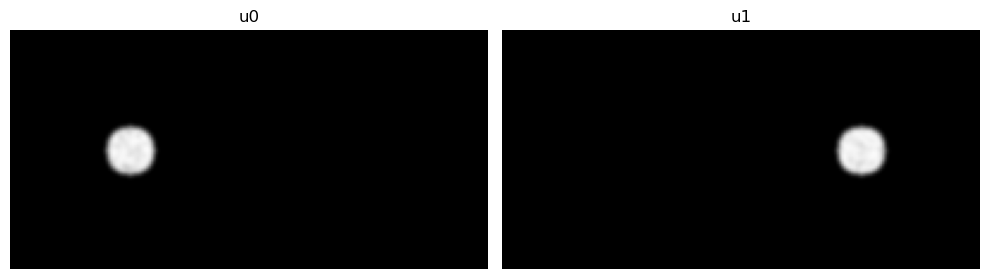

In [14]:
# ler as imagens
path0 = "img/ball-frame01.png"
path1 = "img/ball-frame02.png"
u0_raw = cv2.imread(path0, cv2.IMREAD_GRAYSCALE)
u1_raw = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)

u0 = u0_raw.astype(np.float32) / 255.0
u1 = u1_raw.astype(np.float32) / 255.0

# mostrar imagens
show_side_by_side(u0, u1)

A seguir definimos o passo do método RK4 e o algoritmo principal de interpolação discutido:

In [15]:
def rk4_step(pos, b, h=1.0):
    """
    um passo de RK4 para dγ/dt = b(y(t)).
    """
    k1 = b(pos)
    k2 = b(pos + 0.5*h*k1)
    k3 = b(pos + 0.5*h*k2)
    k4 = b(pos + h*k3)

    return pos + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

def interpolate_with_flow(u0, flow, t=0.5):
    """
    interpola u0 usando um fluxo flow[y,x] = (vx,vy).
    """
    h, w = u0.shape
    out = np.zeros_like(u0)

    # fluxo como função do espaço
    def b_func(pos):
        x, y = pos
        x = np.clip(x, 0, w-1)
        y = np.clip(y, 0, h-1)
        return flow[int(y), int(x)]

    # para cada pixel do frame intermediário
    for y in range(h):
        for x in range(w):
            pos = np.array([x, y], dtype=np.float32)

            # seguir gama(t) -> gama(0) integrando a EDO para trás
            p = pos.copy()
            steps = 10
            dt = -t / steps
            for _ in range(steps):
                p = rk4_step(p, b_func, h=dt)

            px, py = p

            # amostragem bilinear
            if 0 <= px < w-1 and 0 <= py < h-1:
                out[y, x] = cv2.getRectSubPix(u0, (1,1), (px, py))[0,0]

    return out

Achar o fluxo é a parte mais difícil, mas por motivos de simplicidade vamos considerar um fluxo constante e, por informações da imagem, sabemos que ela se deslocou um valor constante de pixels informado.

Assim, conseguiremos testar o método sem entrar nas especificidades do problema de encontrar o fluxo.

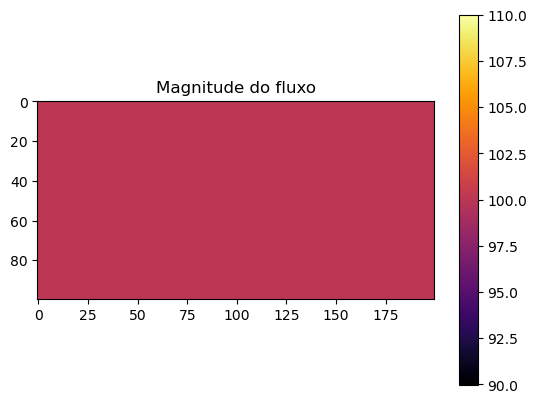

In [16]:

# definindo um fluxo constante onde os pixels se deslocam dx
h, w = u0.shape
dx = 100
dy = 0

flow_const = np.zeros((h, w, 2), np.float32)
flow_const[..., 0] = dx
flow_const[..., 1] = dy

# mostrar o fluxo
def show_flow(flow):
  plt.imshow(np.sqrt(flow[...,0]**2 + flow[...,1]**2), cmap="inferno")
  plt.title("Magnitude do fluxo")
  plt.colorbar()
  plt.show()

show_flow(flow_const)


Agora, calcularemos o frame intermediário utilizando a função definida, comparando com os frames iniciais e finais:

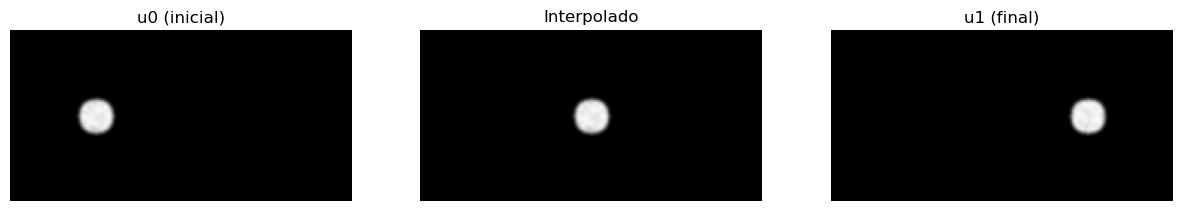

In [17]:
# calcula o frame intermediario
I_mid = interpolate_with_flow(u0, flow_const, t=0.5)

# visualiza a comparação
def show_comparison(u0, I_mid, u1):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1); show(u0, "u0 (inicial)")
  plt.subplot(1,3,2); show(I_mid, "Interpolado")
  plt.subplot(1,3,3); show(u1, "u1 (final)")
  plt.show()

show_comparison(u0, I_mid, u1)

Nesse caso simples, conseguimos verificar que faz sentido: em um fluxo constante no eixo $x$, temos que o frame intermediário entre duas posições é a posição intermediária para cada pixel.

O algoritmo é mais geral e pode ser utilizado para fluxos complexos como discutido.

## Demonstração utilizando o método de Farneback para cálcular o fluxo

Podemos testar nosso algoritmo com algum algoritmo de cálculo de fluxo já implementado, por exemplo o de Farneback que está incluso na OpenCV.

Utilizaremos uma imagem mais complexa, tanto para apresentar um cenário mais complexo, mas também pois apresenta um melhor resultado, já que a imagem possui mais informações e texturas. Quando aplicada ao contexto anterior, por exemplo, poderíamos não ter um resultado correto, por se tratar de uma grande mudança e poucas informações.

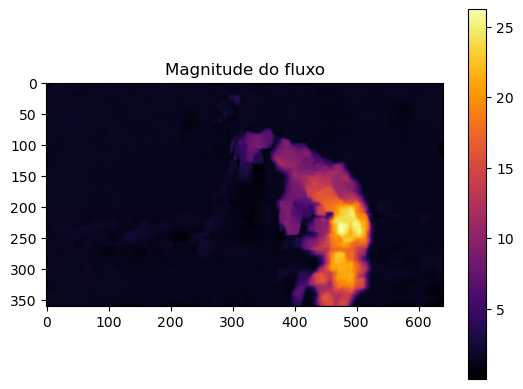

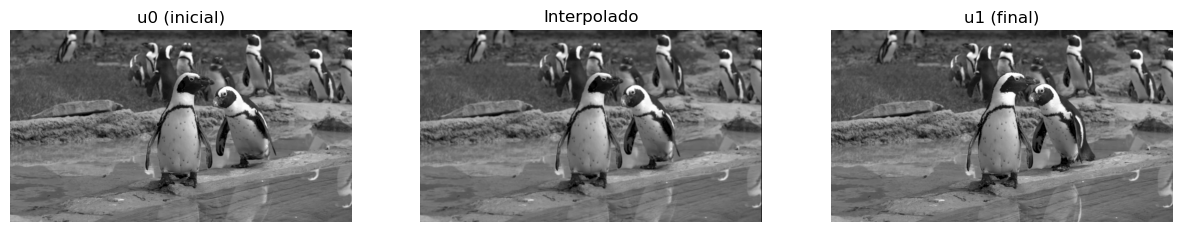

True

In [18]:
# quando ler online
penguin_path0 = "img/penguins-frame01.png"
penguin_path1 = "img/penguins-frame02.png"
penguin_u0_raw = cv2.imread(penguin_path0, cv2.IMREAD_GRAYSCALE)
penguin_u1_raw = cv2.imread(penguin_path1, cv2.IMREAD_GRAYSCALE)

penguin_u0 = penguin_u0_raw.astype(np.float32) / 255.0
penguin_u1 = penguin_u1_raw.astype(np.float32) / 255.0

# calcular o fluxo com farneback utilizando a implementação do OpenCV
flow_farneback = cv2.calcOpticalFlowFarneback(
    penguin_u0_raw, penguin_u1_raw,
    None,
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# mostrar o mapa de fluxo
show_flow(flow_farneback)

# interpolar a imagem
penguin_I_mid = interpolate_with_flow(penguin_u0, flow_farneback.astype(np.float32), t=0.5)
show_comparison(penguin_u0, penguin_I_mid, penguin_u1)

# salvar as imagens utilizadas
cv2.imwrite("img/penguin_u0.png", (penguin_u0*255).astype(np.uint8))
cv2.imwrite("img/penguin_I_mid.png", (penguin_I_mid*255).astype(np.uint8))
cv2.imwrite("img/penguin_u1.png", (penguin_u1*255).astype(np.uint8))

Percebemos que o método utilizado para cálculo de fluxo funciona bem, tanto pela magnitude do fluxo quanto pelo resultado final que ficou realista o suficiente.

![img](img/penguins_comparison.png)

## Conclusão

Ao fim, vimos que o problema de interpolação de frames pode ser modelado como um problema de transporte, onde a imagem vai evoluindo pela EDP e sua solução utiliza EDOs, por conta do método das características.

Essas EDOs podem ser resolvidas utilizando métodos conhecidos, como o Runge-Kutta de ordem 4.

O cálculo do fluxo é um problema grande à parte, que pode envolver diversos métodos ou combinações deles. Independendo do que for escolhido, podemos calcular a imagem final utilizando um algoritmo similar ao apresentado.

A abordagem apresentada se baseia no artigo "Image sequence interpolation using optimal control", que por sua vez implementa o método de controle ótimo. Dessa forma, utilizar com outros métodos de fluxo se faz necessário ajustar o código.


## Referências

CHEN, Kanglin; LORENZ, Dirk A. Image sequence interpolation using optimal control. 2010. Disponível em: https://arxiv.org/abs/1008.0548